In [11]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [180]:
import os
import tskit
import numpy as np
import pyslim
import matplotlib.pyplot as plt

from bprime.tree_utils import load_recrates, load_neutregions
from bprime.models import BGSModel 
from bprime.utils import load_bed_annotation, load_seqlens, RecMap

In [61]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [139]:
DATADIR = '../data/slim_sims/bgsmap/'
tree_files = [os.path.join(DATADIR, f) for f in os.listdir(DATADIR) if f.endswith('.tree')]

In [140]:
len(tree_files)

100

In [154]:
length = 130_000_000
np.linspace(0, length, length // 1000).astype(int)

array([        0,      1000,      2000, ..., 129997999, 129998999,
       130000000])

In [158]:


def get_diversity(file, seed=None):
    ts = pyslim.load(file)
    md = ts.metadata['SLiM']['user_metadata']
    region_length = md['region_length'][0]
    N = md['N'][0]
    #neut_positions, _ = load_neutregions('../data/annotation/neutral_chr10.bed', None, region_length, ratemap=False)
    #neut_positions[-1] += 1 # TODO -- someothing's off by one
    #print(ts.sequence_length)
    recmap = load_recrates('../data/annotation/rec_100kb_chr10.bed', ts.sequence_length)
    rts = pyslim.recapitate(ts, recombination_rate=1e-8, sequence_length=ts.sequence_length,
                            ancestral_Ne=N, random_seed=seed)
    length = int(ts.sequence_length)
    neut_positions = np.linspace(0, length, length // 1000).astype(int)
    return neut_positions, rts.diversity(mode='branch', windows=neut_positions) / (4*N)


pos, pi = get_diversity(tree_files[0])
len(pos), len(pi)

(130000, 129999)

In [159]:
positions = []
pis = []
for file in tree_files:
    pos, pi = get_diversity(file)
    wins = pos[::2]
    ranges = np.stack((wins[:-1], wins[1:])).T
    idx = np.arange(0, ranges.shape[0], 2)
    positions.append(ranges[idx, ...].mean(axis=1))
    pis.append(pi[idx])
    

In [160]:
np.array(positions), np.array(pis)

(array([[1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08],
        [1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08],
        [1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08],
        ...,
        [1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08],
        [1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08],
        [1.00000e+03, 5.00000e+03, 9.00000e+03, ..., 1.29990e+08,
         1.29994e+08, 1.29998e+08]]),
 array([[0.35500898, 0.35500898, 0.35500898, ..., 0.20615443, 0.20615443,
         0.20615443],
        [0.85227119, 0.85227119, 0.85227119, ..., 0.14638981, 0.14639021,
         0.14639413],
        [0.21330481, 0.21330481, 0.21330481, ..., 0.22717678, 0.22717678,
         0.22717678],
        ...,
        [0.64919422, 0.64919422, 0.64919422, ..., 0.149696  , 0.149696  

In [182]:
annot = load_bed_annotation(f"../data/annotation/conserved_by_chrom/conserved_chr10.bed")
seqlens = load_seqlens("/home/vsb/projects/interference/data/annotation/hg19_seqlens.tsv")
recmap = RecMap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt", seqlens=seqlens, conversion_factor=1e-8)

m = BGSModel(recmap, annot,
             seqlens={'chr10': seqlens['chr10']}, 
             w_grid=np.array([1e-7, 5e-7, 1e-8, 1e-9]),
             t_grid=np.array([0.1, 0.01, 0.001, 0.0001]))
pkl_b_file = '~/projects/interference/data/annotation/B_hapmap_exons_phastcons.pkl'
if os.path.exists(pkl_b_file):
    m.load_B(pkl_b_file)
else:
    m.calc_B(step=1_000, ncores=50, nchunks=100)
    #m.calc_B(step=1_000)
    m.save_B(pkl_b_file)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
pre-computing segment contributions...	done.
Genome divided into 100 chunks to be processed on 50 CPUs...


/home/vsb/projects/bprime/notebooks/../bprime/utils.py:377: UserWarning: some positions [135535000] are greater than sequence length (135534747
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


FileNotFoundError: [Errno 2] No such file or directory: '~/projects/interference/data/annotation/B_hapmap_exons_phastcons.pkl'

(0.0, 1.0)

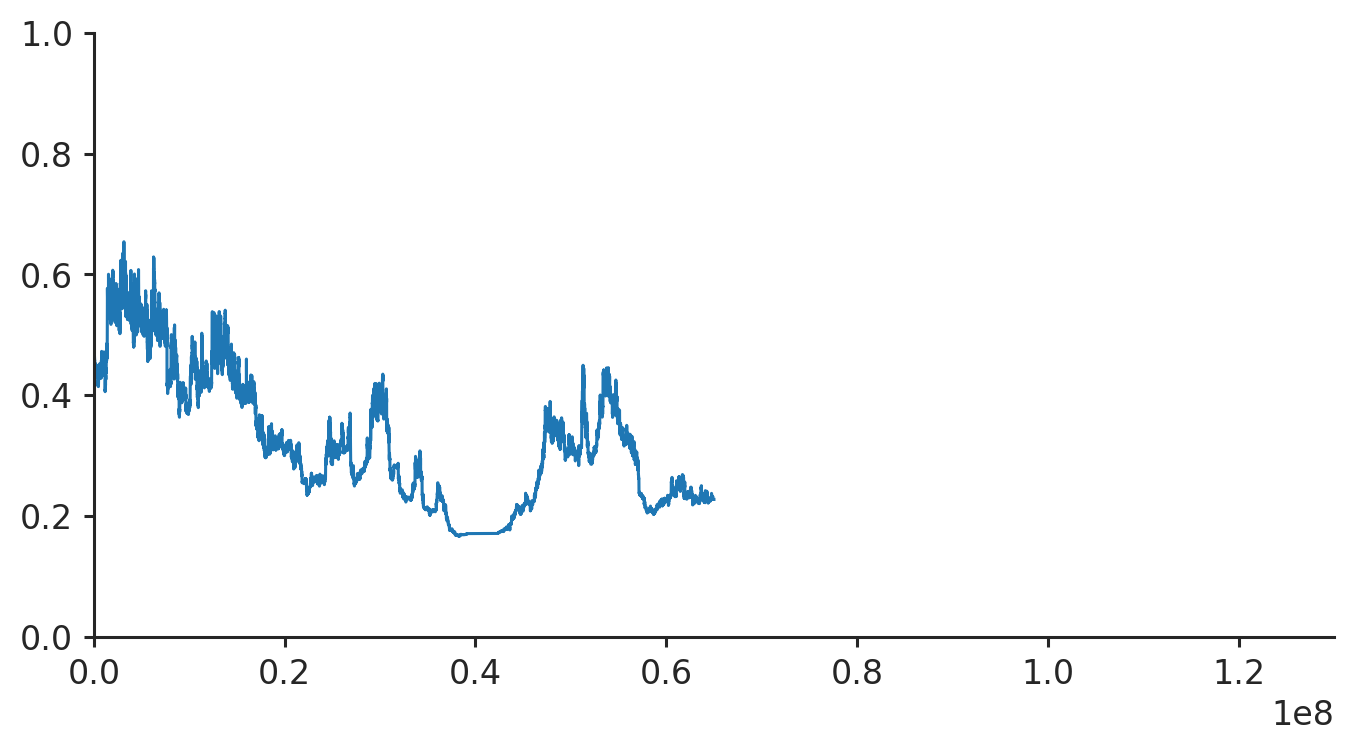

In [167]:
fig, ax = plt.subplots()
ax.plot(positions[0]/2, np.mean(np.array(pis), axis=0))
ax.plot(m.BScores.pos['chr10'], np.exp(1/2*m.BScores.B['chr10'][:, wi, ti, 0]), label='bgspy', alpha=0.7)

ax.set_xlim(0, 1.3e8)
ax.set_ylim(0, 1)
#plt.plot(positions[0], np.median(np.array(pis), axis=0))

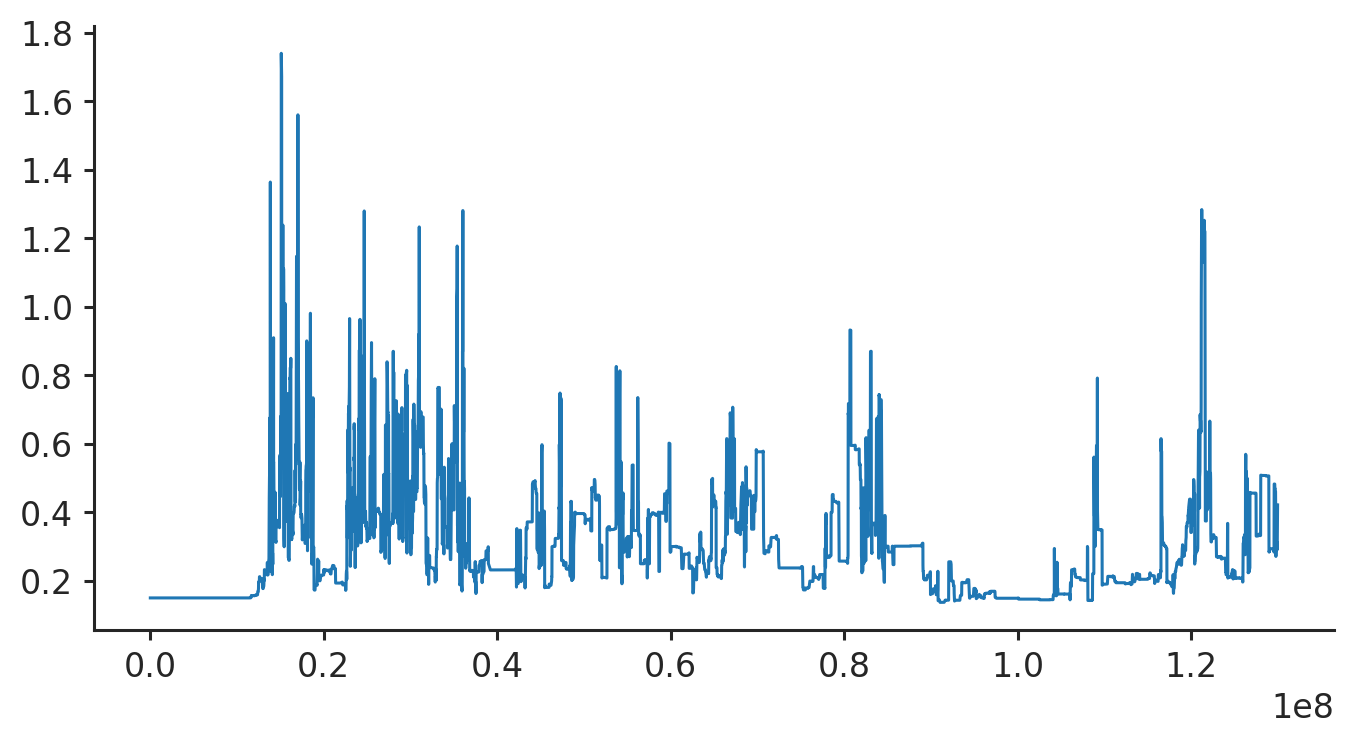

In [91]:
plt.plot(ranges[idx, ...].mean(axis=1), pi[idx])